In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# Import and format crosswalk
df_cross = pd.read_csv('./data/county-cbsa-crosswalk-cleaned.csv')
df_cross = df_cross[['County Code','CBSA Code']]
df_cross = df_cross.rename(columns = {'County Code':'FIPS','CBSA Code':'GTCBSA'})
df_cross['FIPS'] = df_cross['FIPS'].astype(int).astype(str)

In [4]:
# Import vaccination data from CDC
vac_df = pd.read_csv('./data/CDC/COVID-19_Vaccinations_in_the_United_States_County.csv', low_memory=False)

# pull out population for later use
pop_df = vac_df[['FIPS','Census2019']].copy().drop_duplicates()
pop_df = pop_df[pop_df['FIPS'] != 'UNK'].copy()
pop_df['FIPS'] = pop_df['FIPS'].astype(int)

# CDC Vaccination data munging
vac_df = vac_df[['Date', 'FIPS', 'MMWR_week', 'Administered_Dose1_Recip', 'Series_Complete_Yes','Booster_Doses','Census2019']]
vac_df = vac_df.merge(df_cross, on='FIPS', how='left')
vac_df = vac_df[~vac_df['GTCBSA'].isna()]
vac_cbsa_df = vac_df.copy().drop(columns=['FIPS']).groupby(['GTCBSA','Date']).sum().reset_index()
vac_cbsa_df['Date'] = pd.to_datetime(vac_cbsa_df['Date'], infer_datetime_format=True)
vac_cbsa_df['Year'] = pd.DatetimeIndex(vac_cbsa_df['Date']).year
vac_cbsa_df['Week'] = vac_cbsa_df['Date'].dt.isocalendar().week
vac_cbsa_df['Administered_Dose1_Recip_pct'] = vac_cbsa_df['Administered_Dose1_Recip'] / vac_cbsa_df['Census2019']
vac_cbsa_df['Series_Complete_Yes_pct'] = vac_cbsa_df['Series_Complete_Yes'] / vac_cbsa_df['Census2019']
vac_cbsa_df['Booster_Doses_pct'] = vac_cbsa_df['Booster_Doses'] / vac_cbsa_df['Census2019']
vac_cbsa_df = vac_cbsa_df.drop(columns = ['Administered_Dose1_Recip', 'Series_Complete_Yes', 'Booster_Doses', 'Census2019', 'MMWR_week', 'Date'])
del vac_df
vac_cbsa_df.head(3)

GTCBSA  Year  Week  Administered_Dose1_Recip_pct  Series_Complete_Yes_pct  \
0  10100.0  2021    53                      0.000000                 0.000000   
1  10100.0  2022    52                      0.626418                 0.527116   
2  10100.0  2021    53                      0.000000                 0.000000   

   Booster_Doses_pct  
0           0.000000  
1           0.197314  
2           0.000000

In [5]:
# Import testing positivity data from CDC
test_df = pd.read_csv('data/CDC/United_States_COVID-19_County_Level_of_Community_Transmission_Historical_Changes_-_ARCHIVED.csv', low_memory=False)

# Munge data
test_df = test_df.drop(columns = ['state_name', 'county_name'])
test_df = test_df.rename(columns={'fips_code':'FIPS'})
test_df['FIPS'] = test_df['FIPS'].astype(int)
test_df = test_df.merge(pop_df, on='FIPS', how='left')
test_df['FIPS'] = test_df['FIPS'].astype(str)
test_df = test_df[~test_df['FIPS'].isna()]
test_pos_df = test_df[['FIPS','date','percent_test_results_reported_positive_last_7_days', 'Census2019']].copy()
test_pos_df['percent_test_results_reported_positive_last_7_days'] = test_pos_df['percent_test_results_reported_positive_last_7_days'].replace(np.nan, 0)
test_pos_df['percent_test_results_reported_positive_last_7_days'] = test_pos_df['percent_test_results_reported_positive_last_7_days'] / 100
test_pos_df['pos_tests'] = test_pos_df['percent_test_results_reported_positive_last_7_days'] * test_pos_df['Census2019']
test_pos_df = test_pos_df.drop(columns = ['percent_test_results_reported_positive_last_7_days'])
test_pos_df = test_pos_df.merge(df_cross, on='FIPS', how='left')
test_pos_df = test_pos_df[~test_pos_df['GTCBSA'].isna()]
test_pos_df['Date'] = pd.to_datetime(test_pos_df['date'], infer_datetime_format=True)
test_pos_df['Year'] = pd.DatetimeIndex(test_pos_df['Date']).year
test_pos_df['Week'] = test_pos_df['Date'].dt.isocalendar().week
test_pos_df = test_pos_df.drop(columns = ['date', 'Date', 'FIPS'])
test_cbsa_df = test_pos_df.groupby(['GTCBSA', 'Year', 'Week']).sum(numeric_only=True).reset_index()
test_cbsa_df['test_positivity'] = test_cbsa_df['pos_tests'] / test_cbsa_df['Census2019']
del test_df, test_pos_df
test_cbsa_df.head(3)

GTCBSA  Year  Week  Census2019  pos_tests  test_positivity
0  10100.0  2020     4    213340.0        0.0              0.0
1  10100.0  2020     5    298676.0        0.0              0.0
2  10100.0  2020     6    298676.0        0.0              0.0

In [6]:
# Merge datasets
cdc_output_df = test_cbsa_df.merge(vac_cbsa_df, on=['GTCBSA', 'Year','Week'], how='left')
cdc_output_df.head(3)

GTCBSA  Year  Week  Census2019  pos_tests  test_positivity  \
0  10100.0  2020     4    213340.0        0.0              0.0   
1  10100.0  2020     5    298676.0        0.0              0.0   
2  10100.0  2020     6    298676.0        0.0              0.0   

   Administered_Dose1_Recip_pct  Series_Complete_Yes_pct  Booster_Doses_pct  
0                           NaN                      NaN                NaN  
1                           NaN                      NaN                NaN  
2                           NaN                      NaN                NaN

In [7]:
# Export datasets

In [8]:
pos_rates = cdc_output_df[['GTCBSA','Year','Week','test_positivity']].copy()
pos_rates = pos_rates[(pos_rates['Year']==2020) & (pos_rates['Week']>26)][['GTCBSA','test_positivity']].copy()
pos_rates = pos_rates.groupby('GTCBSA').mean().reset_index()
vac_rates = cdc_output_df[['GTCBSA','Year','Week','Series_Complete_Yes_pct']].copy()
vac_rates = vac_rates[(vac_rates['Year']==2021) & (vac_rates['Week']==52)][['GTCBSA','Series_Complete_Yes_pct']].copy()
vac_rates = vac_rates.groupby('GTCBSA').mean().reset_index()

vac_pos = vac_rates.merge(pos_rates, on='GTCBSA', how='inner')
vac_pos = vac_pos[~vac_pos['Series_Complete_Yes_pct'].isna()]
vac_pos = vac_pos[~vac_pos['test_positivity'].isna()]

vac_pos.to_csv('./data/cdc_aggregated.csv', index=False)

PearsonRResult(statistic=-0.3898282894172124, pvalue=4.061729383507319e-31)
SignificanceResult(statistic=-0.5207145173962084, pvalue=4.139289674988596e-58)


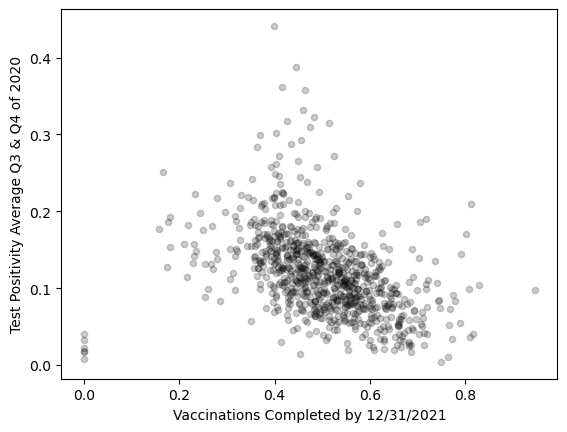

In [9]:
# Inspect data
plt.scatter(vac_pos['Series_Complete_Yes_pct'], vac_pos['test_positivity'], s=20, alpha=0.2, c='black')
plt.xlabel('Vaccinations Completed by 12/31/2021')
plt.ylabel('Test Positivity Average Q3 & Q4 of 2020')

print(stats.pearsonr(vac_pos['Series_Complete_Yes_pct'], vac_pos['test_positivity']))
print(stats.spearmanr(vac_pos['Series_Complete_Yes_pct'], vac_pos['test_positivity']))

# Mortality Data

Your request for the following files has been approved:  
 
•            Detailed Mortality - All Counties (all states, all counties, plus cities of 100,000 or more population) for years 2018, 2020, 2021, and 2022.  
 
Your files has been placed on a FTP site.  
 
The logon for the FileZilla is as follows:                                                                                                
 
Hostname: The host: eft.cdc.gov  
Username: User ID: part2  
Password; 68440GyT  
Port:  22  
 
Your file folder name is 20231227.McLeod to access your requested files.  
 
Please let me know once you have successfully downloaded these files to your own secure site.    
 
The FTP site has limited space so your files will be deleted within 14 days.   If you need more time, please let me know.  
 
The passphrase/passwords for these files are:  
MortAC#2018(Mcleod)  
MortAC#2020(Mcleod)  
MortAC#2021(Mcleod)  
2022 Please follow-up with me after the beginning of the year for the release date  
Once your research has been completed or you are coming up on a year please review and sign the certificate of destruction and return to me.  Feel free to let me know if you have any other questions. 

In [10]:
path = './data/CDC/'
f2017 = 'VS17MORTDUSMCPUB.txt'
f2018 = 'MULT2018.USPSAllCnty/Mort2018US.AllCnty.txt'
f2019 = 'VS19MORTDUSMCPUB_r20210304.txt'
f2020 = 'MULT2020.USPSAllCnty/MULT2020.USAllCnty.txt'
f2021 = 'MULT2021.AllCnty/MULT2021US.AllCnty.txt'

In [11]:
def cdc_parser(s):
    atypes = {'1':'years',
              '2':'months',
              '4':'days',
              '5':'hours',
              '6':'minutes',
              '9':'not_stated'}

    a_recodes = {'01':'Under 1 Month',
                '02':'1 - 11 Months',
                '03':'1 Year',
                '04':'2 Years',
                '05':'3 Years',
                '06':'4 Years',
                '07':'5 - 9 Years', 
                '08':'10 - 14 Years',
                '09':'15 - 19 Years',
                '10':'20 - 24 Years',
                '11':'25 - 29 Years',
                '12':'30 - 34 Years',
                '13':'35 - 39 Years',
                '14':'40 - 44 Years',
                '15':'45 - 49 Years',
                '16':'50 - 54 Years',
                '17':'55 - 59 Years',
                '18':'60 - 64 Years',
                '19':'65 - 69 Years',
                '20':'70 - 74 Years',
                '21':'75 - 79 Years',
                '22':'80 - 84 Years',
                '23':'85 - 89 Years',
                '24':'90 - 94 Years',
                '25':'95 - 99 Years',
                '26':'100 Years and Over',
                '27':'not_stated',}

    places = {'1': 'Hospital - Inpatient',
              '2': 'Hospital - Outpatient',
              '3': 'Hospital - Dead on Arrival',
              '4': 'Decedent\'s home',
              '5': 'Hospice',
              '6': 'Nursing Home',
              '7': 'Other',
              '9': 'Unknown'}

    death_types =  {'1':'Accident',
                    '2':'Suicide',
                    '3':'Homicide',
                    '4':'Pending investigation',
                    '5':'Could not determine',
                    '6':'Self-Inflicted',
                    '7':'Natural',
                    ' ':'Not specified'}
    
    state_of_occurrence = s[20:22]
    county_of_occurrence = s[22:25]
    state_of_residence = s[32:34]
    county_of_residence = s[34:37]
    education   = s[60:63].replace(' ', '')
    month_of_death = s[64:66]
    sex = s[68]
    age_type = atypes[s[69]] if s[69] in atypes else 'not_stated'
    age_val = s[70:73]
    age_val2 = a_recodes[s[76:78]] if s[76:78] in a_recodes else 'not_stated'
    place_of_death = places[s[82]] if s[82] in places else 'not_stated'
    marital_status = s[83] # N and U are "not listed" and "unknown"
    day_of_week = s[84] # Sun = 1, Sat = 7, Unknown = 9
    year = s[101:105]
    manner_of_death = death_types[s[106]] if s[106] in death_types else 'not_stated' 
    icd_code = s[145:149]

    return [state_of_occurrence,county_of_occurrence,state_of_residence,county_of_residence,
            education,month_of_death,sex,age_type,age_val,age_val2,place_of_death,
            marital_status,day_of_week,year,manner_of_death,icd_code]

In [12]:
f = open(path+f2018, 'r')
data = f.read()
data = data.split('\n')

df_dict = {}

cols = ['state_of_occurrence','county_of_occurrence','state_of_residence','county_of_residence',
            'education','month_of_death','sex','age_type','age_val','age_val2','place_of_death',
            'marital_status','day_of_week','year','manner_of_death','icd_code']


for idx, i in enumerate(data):
    try:
        d = cdc_parser(i)
        df_dict[idx] = d
    except:
        print(f'Error on row {idx} of {len(data)-1}')

df = pd.DataFrame(df_dict)
df = df.T.copy()
df.columns = cols
display(df)
df.to_csv(path+'PROCESSED_cdc_mortality_2018.csv', index=False)

Error on row 2846305 of 2846305


state_of_occurrence county_of_occurrence state_of_residence  \
0                        AK                  020                 WY   
1                        AK                  020                 AK   
2                        AK                  170                 AK   
3                        AK                  020                 AK   
4                        AK                  020                 AK   
...                     ...                  ...                ...   
2846300                  NY                  005                 NY   
2846301                  NY                  061                 NY   
2846302                  NY                  047                 NY   
2846303                  NY                  061                 NY   
2846304                  NY                  061                 NY   

        county_of_residence education month_of_death sex age_type age_val  \
0                       033         3             01   F    years     046   
1                       020         3             01   M    years     028   
2                       170         6             01   M    years     093   
3                       020         2             01   M    years     090   
4                       220         4             01   F    years     031   
...                     ...       ...            ...  ..      ...     ...   
2846300                 005         9             10   F    years     069   
2846301                 061         1             12   F    hours     003   
2846302                 047         1             12   F   months     003   
2846303                 061         3             10   M    years     064   
2846304                 061         9             05   F    years     083   

              age_val2        place_of_death marital_status day_of_week  year  \
0        45 - 49 Years  Hospital - Inpatient              D           2  2018   
1        25 - 29 Years                 Other              S           4  2018   
2        90 - 94 Years          Nursing Home              D           3  2018   
3        90 - 94 Years  Hospital - Inpatient              W           7  2018   
4        30 - 34 Years  Hospital - Inpatient              S           2  2018   
...                ...                   ...            ...         ...   ...   
2846300  65 - 69 Years          Nursing Home              M           6  2018   
2846301  Under 1 Month  Hospital - Inpatient              S           3  2018   
2846302  1 - 11 Months  Hospital - Inpatient              S           2  2018   
2846303  60 - 64 Years          Nursing Home              S           6  2018   
2846304  80 - 84 Years       Decedent's home              U           1  2018   

        manner_of_death icd_code  
0               Natural     A419  
1              Accident     V475  
2               Natural     C61   
3               Natural     A419  
4               Natural     K701  
...                 ...      ...  
2846300         Natural     J961  
2846301         Natural     P072  
2846302         Natural     Q913  
2846303         Natural     I251  
2846304         Natural     C349  

[2846305 rows x 16 columns]

In [13]:
f = open(path+f2019, 'r')
data = f.read()
data = data.split('\n')

df_dict = {}

cols = ['state_of_occurrence','county_of_occurrence','state_of_residence','county_of_residence',
            'education','month_of_death','sex','age_type','age_val','age_val2','place_of_death',
            'marital_status','day_of_week','year','manner_of_death','icd_code']


for idx, i in enumerate(data):
    try:
        d = cdc_parser(i)
        df_dict[idx] = d
    except:
        print(f'Error on row {idx} of {len(data)-1}')

df = pd.DataFrame(df_dict)
df = df.T.copy()
df.columns = cols
display(df)
df.to_csv(path+'PROCESSED_cdc_mortality_2019.csv', index=False)

Error on row 2861523 of 2861523


state_of_occurrence county_of_occurrence state_of_residence  \
0                                                                     
1                                                                     
2                                                                     
3                                                                     
4                                                                     
...                     ...                  ...                ...   
2861518                                                               
2861519                                                               
2861520                                                               
2861521                                                               
2861522                                                               

        county_of_residence education month_of_death sex age_type age_val  \
0                                   4             01   M    years     036   
1                                   4             01   F    years     063   
2                                   3             01   F    years     097   
3                                   3             01   M    years     076   
4                                   4             01   M    years     064   
...                     ...       ...            ...  ..      ...     ...   
2861518                             9             05   M    years     049   
2861519                             9             10   M    years     066   
2861520                             8             12   M    years     050   
2861521                             3             12   F    years     082   
2861522                             2             12   F    years     047   

              age_val2         place_of_death marital_status day_of_week  \
0        35 - 39 Years  Hospital - Outpatient              M           6   
1        60 - 64 Years           Nursing Home              M           5   
2        95 - 99 Years           Nursing Home              W           5   
3        75 - 79 Years        Decedent's home              M           5   
4        60 - 64 Years   Hospital - Inpatient              M           7   
...                ...                    ...            ...         ...   
2861518  45 - 49 Years   Hospital - Inpatient              U           7   
2861519  65 - 69 Years        Decedent's home              S           2   
2861520  50 - 54 Years   Hospital - Inpatient              M           2   
2861521  80 - 84 Years        Decedent's home              W           1   
2861522  45 - 49 Years   Hospital - Inpatient              S           1   

         year manner_of_death icd_code  
0        2019         Natural     E141  
1        2019         Natural     C55   
2        2019         Natural     I698  
3        2019         Natural     C80   
4        2019         Natural     I633  
...       ...             ...      ...  
2861518  2019         Natural     K590  
2861519  2019         Natural     C61   
2861520  2019         Natural     D761  
2861521  2019         Natural     E854  
2861522  2019         Natural     N185  

[2861523 rows x 16 columns]

In [14]:
f = open(path+f2020, 'r')
data = f.read()
data = data.split('\n')

df_dict = {}

cols = ['state_of_occurrence','county_of_occurrence','state_of_residence','county_of_residence',
            'education','month_of_death','sex','age_type','age_val','age_val2','place_of_death',
            'marital_status','day_of_week','year','manner_of_death','icd_code']


for idx, i in enumerate(data):
    try:
        d = cdc_parser(i)
        df_dict[idx] = d
    except:
        print(f'Error on row {idx} of {len(data)-1}')

df = pd.DataFrame(df_dict)
df = df.T.copy()
df.columns = cols
display(df)
df.to_csv(path+'PROCESSED_cdc_mortality_2020.csv', index=False)

Error on row 3390278 of 3390278


state_of_occurrence county_of_occurrence state_of_residence  \
0                        AK                  070                 AK   
1                        AK                  020                 AK   
2                        AK                  020                 AK   
3                        AK                  020                 AK   
4                        AK                  170                 AK   
...                     ...                  ...                ...   
3390273                  NY                  081                 NY   
3390274                  NY                  047                 NY   
3390275                  NY                  005                 NY   
3390276                  NY                  005                 NY   
3390277                  NY                  085                 NY   

        county_of_residence education month_of_death sex age_type age_val  \
0                       070         1             01   F    years     086   
1                       020         6             01   M    years     064   
2                       020         4             01   F    years     039   
3                       020         3             01   F    years     059   
4                       170         3             01   M    years     069   
...                     ...       ...            ...  ..      ...     ...   
3390273                 081         3             12   M    years     071   
3390274                 047         9             12   M    years     060   
3390275                 005         9             12   M    years     067   
3390276                 005         9             12   M    years     054   
3390277                 085         9             04   M    years     067   

              age_val2         place_of_death marital_status day_of_week  \
0        85 - 89 Years   Hospital - Inpatient              W           6   
1        60 - 64 Years        Decedent's home              S           5   
2        35 - 39 Years        Decedent's home              D           4   
3        55 - 59 Years        Decedent's home              S           5   
4        65 - 69 Years  Hospital - Outpatient              M           4   
...                ...                    ...            ...         ...   
3390273  70 - 74 Years        Decedent's home              W           5   
3390274  60 - 64 Years        Decedent's home              U           2   
3390275  65 - 69 Years        Decedent's home              U           6   
3390276  50 - 54 Years        Decedent's home              U           2   
3390277  65 - 69 Years        Decedent's home              S           2   

         year manner_of_death icd_code  
0        2020         Natural     I120  
1        2020         Suicide     X74   
2        2020         Suicide     X74   
3        2020         Natural     C139  
4        2020         Natural     I219  
...       ...             ...      ...  
3390273  2020         Natural     I250  
3390274  2020         Natural     E149  
3390275  2020         Natural     B227  
3390276  2020         Natural     N319  
3390277  2020         Natural     I250  

[3390278 rows x 16 columns]

In [15]:
f = open(path+f2021, 'r')
data = f.read()
data = data.split('\n')

df_dict = {}

cols = ['state_of_occurrence','county_of_occurrence','state_of_residence','county_of_residence',
            'education','month_of_death','sex','age_type','age_val','age_val2','place_of_death',
            'marital_status','day_of_week','year','manner_of_death','icd_code']


for idx, i in enumerate(data):
    try:
        d = cdc_parser(i)
        df_dict[idx] = d
    except:
        print(f'Error on row {idx} of {len(data)-1}')

df = pd.DataFrame(df_dict)
df = df.T.copy()
df.columns = cols
display(df)
df.to_csv(path+'PROCESSED_cdc_mortality_2021.csv', index=False)

Error on row 3472120 of 3472120


state_of_occurrence county_of_occurrence state_of_residence  \
0                        AK                  170                 AK   
1                        AK                  122                 AK   
2                        AK                  020                 AK   
3                        AK                  170                 AK   
4                        AK                  180                 AK   
...                     ...                  ...                ...   
3472115                  NY                  047                 NY   
3472116                  NY                  005                 NY   
3472117                  NY                  081                 NY   
3472118                  NY                  005                 NY   
3472119                  NY                  047                 NY   

        county_of_residence education month_of_death sex age_type age_val  \
0                       170         7             01   F    years     080   
1                       122         3             01   M    years     068   
2                       020         3             01   F    years     054   
3                       170         3             01   M    years     075   
4                       180         1             01   M    years     085   
...                     ...       ...            ...  ..      ...     ...   
3472115                 081         1             12   M    years     064   
3472116                 005         3             12   M    years     044   
3472117                 081         1             12   F    years     091   
3472118                 087         1             12   M    years     067   
3472119                 047         3             11   M    years     072   

              age_val2         place_of_death marital_status day_of_week  \
0        80 - 84 Years        Decedent's home              D           1   
1        65 - 69 Years        Decedent's home              M           2   
2        50 - 54 Years   Hospital - Inpatient              M           7   
3        75 - 79 Years        Decedent's home              D           1   
4        85 - 89 Years        Decedent's home              S           1   
...                ...                    ...            ...         ...   
3472115  60 - 64 Years   Hospital - Inpatient              S           1   
3472116  40 - 44 Years   Hospital - Inpatient              D           3   
3472117  90 - 94 Years  Hospital - Outpatient              W           1   
3472118  65 - 69 Years           Nursing Home              D           1   
3472119  70 - 74 Years           Nursing Home              W           1   

         year        manner_of_death icd_code  
0        2021                Natural     C851  
1        2021                Natural     J449  
2        2021               Accident     W65   
3        2021                Natural     I714  
4        2021                Natural     C169  
...       ...                    ...      ...  
3472115  2021                Natural     I619  
3472116  2021                Natural     K729  
3472117  2021                Natural     I10   
3472118  2021  Pending investigation     R99   
3472119  2021                Natural     I251  

[3472120 rows x 16 columns]

In [16]:
tdf = df.head(100)
tdf.to_csv(path+'sample_cdc_data.csv', index=False)

In [17]:
icd  = df['icd_code'].unique().tolist()
icd_full = df['icd_code'].tolist()

In [18]:
icd_freq = {k:0 for k in icd}
for i in icd_full:
    icd_freq[i] += 1

In [19]:
tdf = pd.DataFrame({'Code':icd_freq.keys(), 'Count': icd_freq.values()})
tdf = tdf.sort_values('Count', ascending=False)
tdf.head(20)

Code   Count
15   U071  417900
27   I251  162549
42   C349  130349
25   G309  112048
1    J449  108317
61   I219   98742
10   F03    91923
79   I250   78619
12   I500   61100
7    I64    52893
57   C259   46364
59   X44    44437
155  X42    43493
31   C509   42518
110  I119   40955
83   A419   39150
56   G20    38300
89   C189   36460
105  G311   36364
77   J189   33677